In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import os
import tensorflow as tf
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image
from tensorflow.keras import datasets, layers, models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

In [220]:
sample_size = 270
width = 150
height = 150

In [221]:
files = ['A', 'B','C']
file_path = "D:/TITO/Documents/BANGKIT/capstone/prototype3/data/{}"
data = {}
for f in files:
    data[f]=[]
for col in files:
    os.chdir(file_path.format(col))
    for i in os.listdir(os.getcwd()):
        if i.endswith('.jpg'):
            data[col].append(i)
        if i.endswith('.png'):
            data[col].append(i)
        if i.endswith('.jpeg'):
            data[col].append(i)

In [222]:
print(len(data['A']))
print(len(data['B']))
print(len(data['C']))

90
90
90


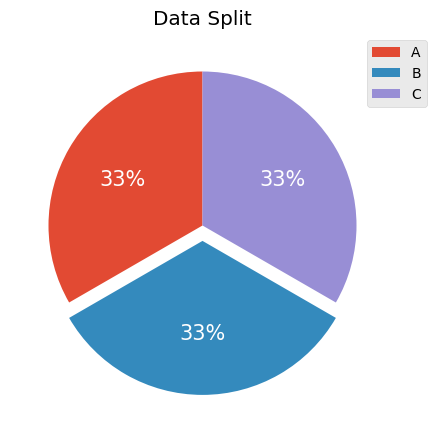

In [223]:
sizes = [len(data['A']), len(data['B']), len(data['C'])]
explode = (0, 0.1, 0) 

plt.figure(figsize=(10, 5), dpi=100)
plt.pie(x=sizes, autopct='%1.0f%%', shadow=False, textprops={'color': "w", "fontsize": 15}, startangle=90, explode=explode)
plt.legend(files, bbox_to_anchor=(0.4, 0, .7, 1))
plt.title("Data Split")
plt.show()

In [224]:
start = time.time()
image_data = []
image_target = []

for title in files:
    os.chdir(file_path.format(title))
    counter = 0
    for i in data[title]:
        img = cv2.imread(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image_data.append(cv2.resize(img,(width, height)))
        image_target.append(title)
        counter += 1
        if counter == sample_size:
            break
    clear_output(wait=True)
    print("Compiled Class",title)
calculate_time = time.time() - start
print("Calculate Time",round(calculate_time,5))

Compiled Class C
Calculate Time 1.34777


In [225]:
image_data = np.array(image_data)
size = image_data.shape[0]
image_data.shape

(270, 150, 150, 3)

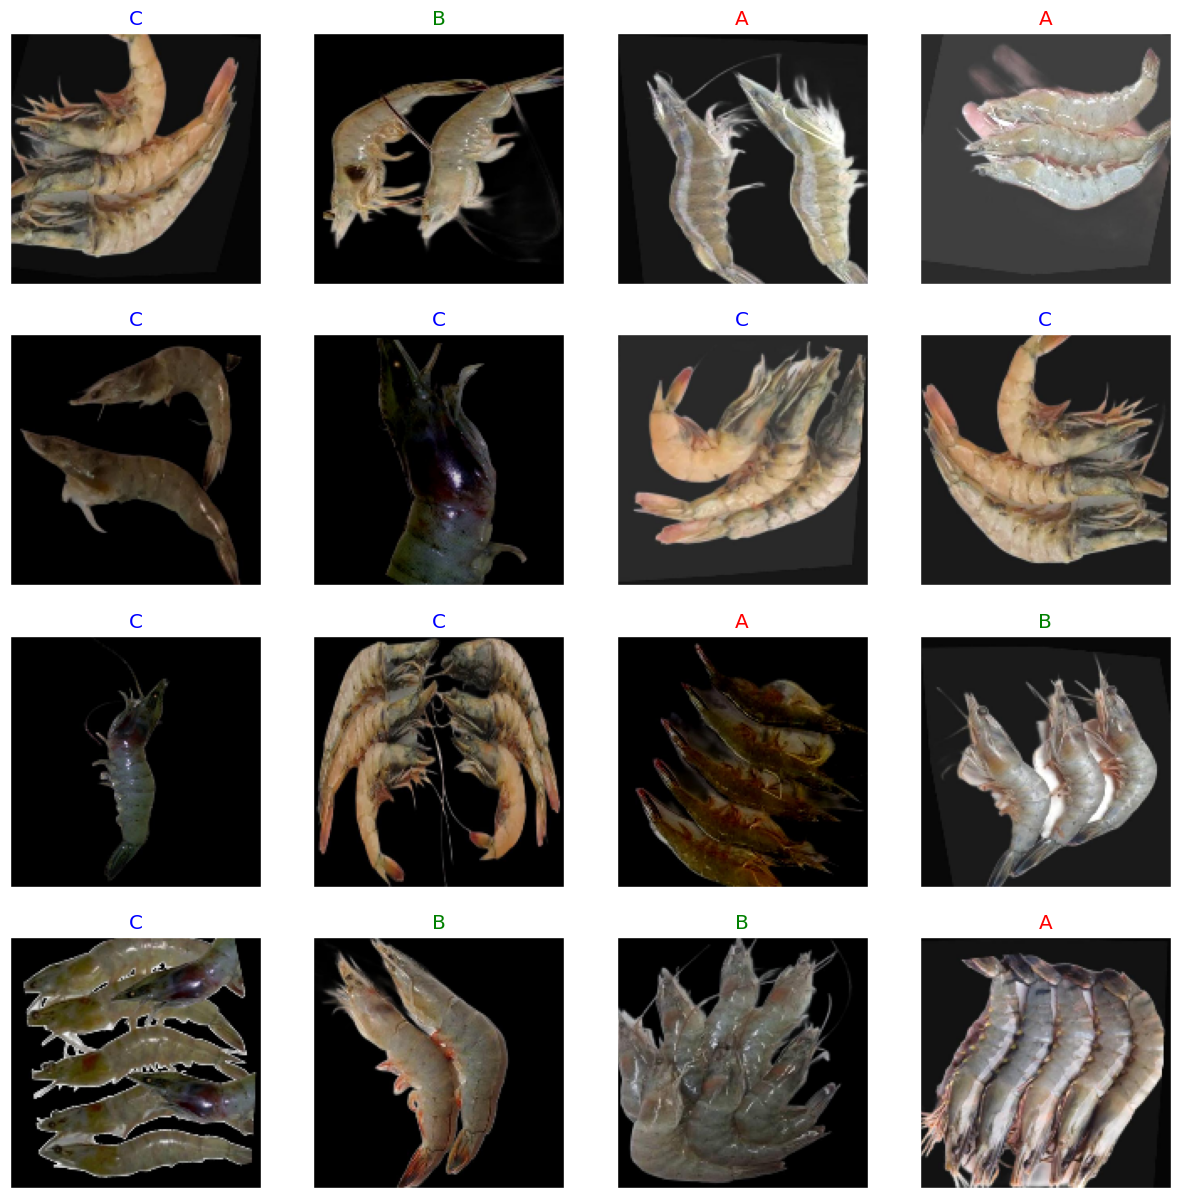

In [226]:
plt.figure(figsize=(15,15))
for i in range(1,17):
    fig = np.random.choice(np.arange(size))
    plt.subplot(4,4,i)
    plt.imshow(image_data[fig])
    if image_target[fig]=='A':
        c='red'
    elif image_target[fig]=='B':
        c='green'
    else:
        c='blue'
    plt.title(image_target[fig], color=c)
    plt.xticks([]), plt.yticks([])
plt.show()

In [227]:
labels = LabelEncoder()
labels.fit(image_target)

LabelEncoder()

In [228]:
X = image_data / 255.0
y = labels.transform(image_target)
train_images, test_images, train_labels, test_labels = train_test_split(X,y, test_size=0.3, random_state=123)


In [229]:
base_model = tf.keras.applications.MobileNet(input_shape=(width, height, 3), include_top=False, weights='imagenet')
base_model.trainable = False

In [230]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 75, 75, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 75, 75, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 75, 75, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 75, 75, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 75, 75, 32)       128       
 ation)                                         

In [231]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(3, activation='softmax')
# ])

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(3, activation='softmax')
])

In [232]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                patience=25,
                                                restore_best_weights=True)


In [233]:
# model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics=['accuracy'])

# history = model.fit(train_images, train_labels, epochs=100,
#                     validation_data=(test_images, test_labels), callbacks=[callback])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.CategoricalAccuracy()])

def lr_scheduler(epoch):
    return 0.001 * np.exp(-0.1 * epoch)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Train the model
history = model.fit(train_images, train_labels, epochs=50, validation_data=(test_images, test_labels), callbacks=[lr_callback, callback])

Epoch 1/50
6/6 [==============================] - 2s 207ms/step - loss: 1.9445 - accuracy: 0.3492 - categorical_accuracy: 0.2698 - val_loss: 0.9961 - val_accuracy: 0.5062 - val_categorical_accuracy: 0.2716 - lr: 0.0010
Epoch 2/50
6/6 [==============================] - 1s 95ms/step - loss: 0.8902 - accuracy: 0.5979 - categorical_accuracy: 0.3122 - val_loss: 0.7941 - val_accuracy: 0.7037 - val_categorical_accuracy: 0.3333 - lr: 9.0484e-04
Epoch 3/50
6/6 [==============================] - 0s 83ms/step - loss: 0.5927 - accuracy: 0.7831 - categorical_accuracy: 0.2910 - val_loss: 0.7714 - val_accuracy: 0.6667 - val_categorical_accuracy: 0.2469 - lr: 8.1873e-04
Epoch 4/50
6/6 [==============================] - 0s 84ms/step - loss: 0.4073 - accuracy: 0.8783 - categorical_accuracy: 0.3228 - val_loss: 0.6680 - val_accuracy: 0.6914 - val_categorical_accuracy: 0.3210 - lr: 7.4082e-04
Epoch 5/50
6/6 [==============================] - 1s 96ms/step - loss: 0.3489 - accuracy: 0.8677 - categorical_accu

3/3 - 0s - loss: 0.3889 - accuracy: 0.8765 - categorical_accuracy: 0.3210 - 151ms/epoch - 50ms/step


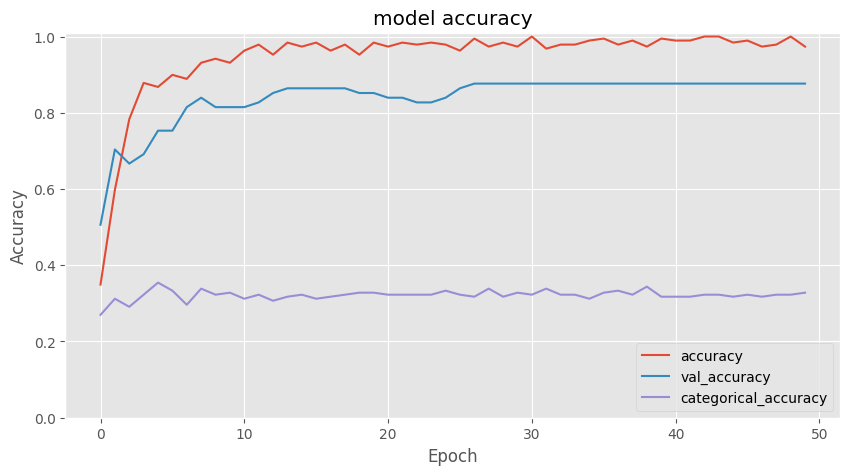

In [234]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.title('model accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.01])
plt.legend(loc='lower right')

test_acc = model.evaluate(test_images,  test_labels, verbose=2)

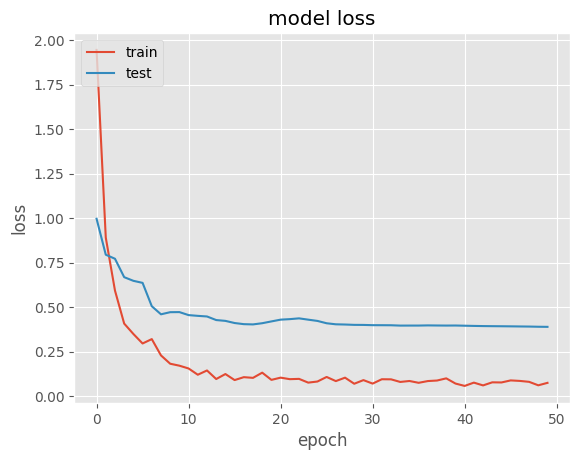

In [235]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [236]:
result=model.evaluate(train_images, train_labels)

6/6 [==============================] - 0s 50ms/step - loss: 0.0240 - accuracy: 1.0000 - categorical_accuracy: 0.3228


In [237]:
result=model.evaluate(test_images, test_labels)

3/3 [==============================] - 0s 41ms/step - loss: 0.3889 - accuracy: 0.8765 - categorical_accuracy: 0.3210


In [238]:
for i in range(len(model.metrics_names)):
    print(model.metrics_names[i],":",result[i])

loss : 0.3888643980026245
accuracy : 0.8765432238578796
categorical_accuracy : 0.32098764181137085


In [239]:
# model.summary()

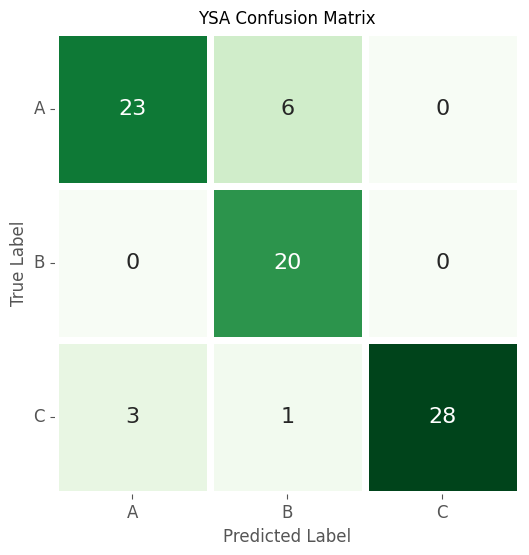

In [240]:
y_pred = model.predict(test_images)

def toClass(pred):

    class_ = np.zeros(len(pred))
    for i in range(len(pred)):
        index = pred[i].argmax()
        class_[i] = index

    return class_

cm = confusion_matrix(test_labels,toClass(y_pred))

df1 = pd.DataFrame(columns=["A","B", "C"], index= ["A","B", "C"], data= cm )

f,ax = plt.subplots(figsize=(6,6))

sns.heatmap(df1, annot=True,cmap="Greens", fmt= '.0f',ax=ax,linewidths = 5, cbar = False,annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("True Label")
plt.title("YSA Confusion Matrix", size = 12)
plt.show()

In [241]:
import sklearn.metrics as metrics

precision = metrics.precision_score(test_labels, toClass(y_pred), average='macro')
print('Precision: %f' % precision)

Precision: 0.875119


In [242]:
recall = metrics.recall_score(test_labels, toClass(y_pred), average='macro')
print('Recall: %f' % recall)

Recall: 0.889368


In [243]:
f1 = metrics.f1_score(test_labels, toClass(y_pred), average='macro')
print('F1 score: %f' % f1)

F1 score: 0.873587


In [244]:
print("Number of layers in the base model: ", len(base_model.layers))
base_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_stop = 75

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_stop]:
  layer.trainable = False
model.summary()

Number of layers in the base model:  86
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_7   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_14 (Dense)            (None, 64)                65600     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 3)                 195       
                                                                 
Total params: 

In [245]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0000001), loss='sparse_categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.CategoricalAccuracy()])

def lr_scheduler(epoch):
    return 0.001 * np.exp(-0.1 * epoch)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Train the model
history = model.fit(train_images, train_labels, epochs=30, validation_data=(test_images, test_labels), callbacks=[lr_callback, callback])

Epoch 1/30
6/6 [==============================] - 6s 362ms/step - loss: 0.5322 - accuracy: 0.8360 - categorical_accuracy: 0.3280 - val_loss: 0.2076 - val_accuracy: 0.9136 - val_categorical_accuracy: 0.3827 - lr: 0.0010
Epoch 2/30
6/6 [==============================] - 1s 90ms/step - loss: 0.0568 - accuracy: 0.9894 - categorical_accuracy: 0.3175 - val_loss: 1.1576 - val_accuracy: 0.7160 - val_categorical_accuracy: 0.6173 - lr: 9.0484e-04
Epoch 3/30
6/6 [==============================] - 1s 93ms/step - loss: 0.0712 - accuracy: 0.9788 - categorical_accuracy: 0.3175 - val_loss: 3.3899 - val_accuracy: 0.5926 - val_categorical_accuracy: 0.7037 - lr: 8.1873e-04
Epoch 4/30
6/6 [==============================] - 1s 93ms/step - loss: 0.0444 - accuracy: 0.9841 - categorical_accuracy: 0.3175 - val_loss: 3.5466 - val_accuracy: 0.5556 - val_categorical_accuracy: 0.7037 - lr: 7.4082e-04
Epoch 5/30
6/6 [==============================] - 1s 90ms/step - loss: 0.0345 - accuracy: 0.9947 - categorical_accu

3/3 - 0s - loss: 0.2746 - accuracy: 0.9259 - categorical_accuracy: 0.4074 - 151ms/epoch - 50ms/step


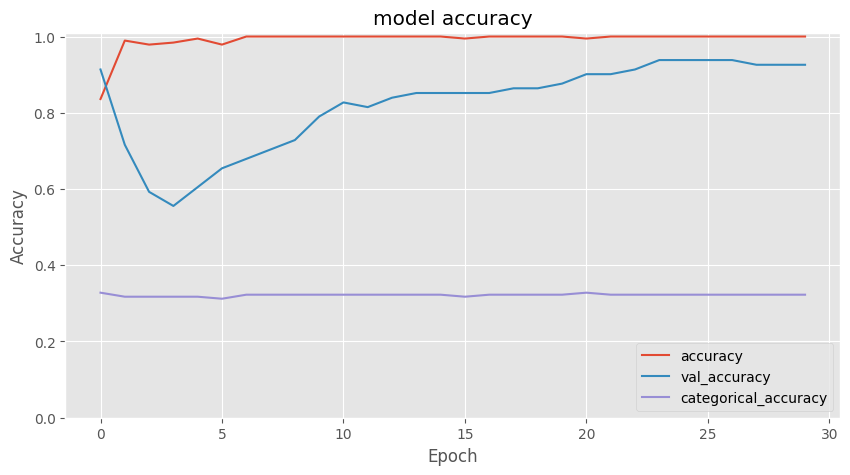

In [246]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.title('model accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.01])
plt.legend(loc='lower right')

test_acc = model.evaluate(test_images,  test_labels, verbose=2)

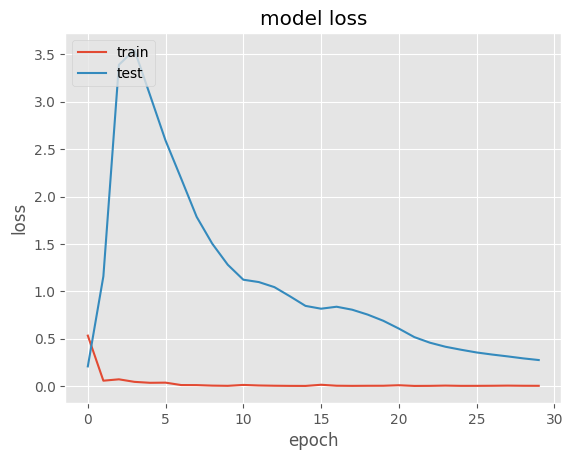

In [247]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [248]:
result=model.evaluate(train_images, train_labels)

6/6 [==============================] - 0s 51ms/step - loss: 4.6361e-05 - accuracy: 1.0000 - categorical_accuracy: 0.3228


In [249]:
result=model.evaluate(test_images, test_labels)

3/3 [==============================] - 0s 42ms/step - loss: 0.2746 - accuracy: 0.9259 - categorical_accuracy: 0.4074


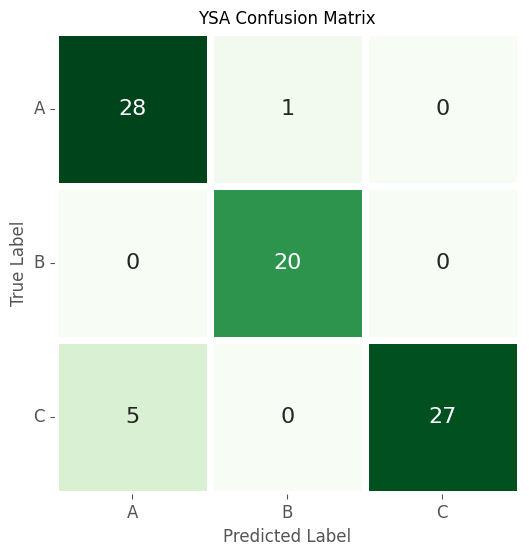

In [250]:
y_pred = model.predict(test_images)

def toClass(pred):

    class_ = np.zeros(len(pred))
    for i in range(len(pred)):
        index = pred[i].argmax()
        class_[i] = index

    return class_

cm = confusion_matrix(test_labels,toClass(y_pred))

df1 = pd.DataFrame(columns=["A","B", "C"], index= ["A","B", "C"], data= cm )

f,ax = plt.subplots(figsize=(6,6))

sns.heatmap(df1, annot=True,cmap="Greens", fmt= '.0f',ax=ax,linewidths = 5, cbar = False,annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("True Label")
plt.title("YSA Confusion Matrix", size = 12)
plt.show()

In [251]:
import sklearn.metrics as metrics

precision = metrics.precision_score(test_labels, toClass(y_pred), average='macro')
print('Precision: %f' % precision)

Precision: 0.933622


In [252]:
recall = metrics.recall_score(test_labels, toClass(y_pred), average='macro')
print('Recall: %f' % recall)

Recall: 0.936422


In [253]:
f1 = metrics.f1_score(test_labels, toClass(y_pred), average='macro')
print('F1 score: %f' % f1)

F1 score: 0.931363


In [254]:
def Prediction(image):

    global width, height, files, labels

    img = cv2.resize(image,(150,150))
    img = np.expand_dims(img, axis=0)  

    test = img / 255.0

    pred = model.predict(test)
    class_list = ['A', 'B', 'C']
    
    predicted_class = class_list[np.argmax(pred[0])]

    return predicted_class

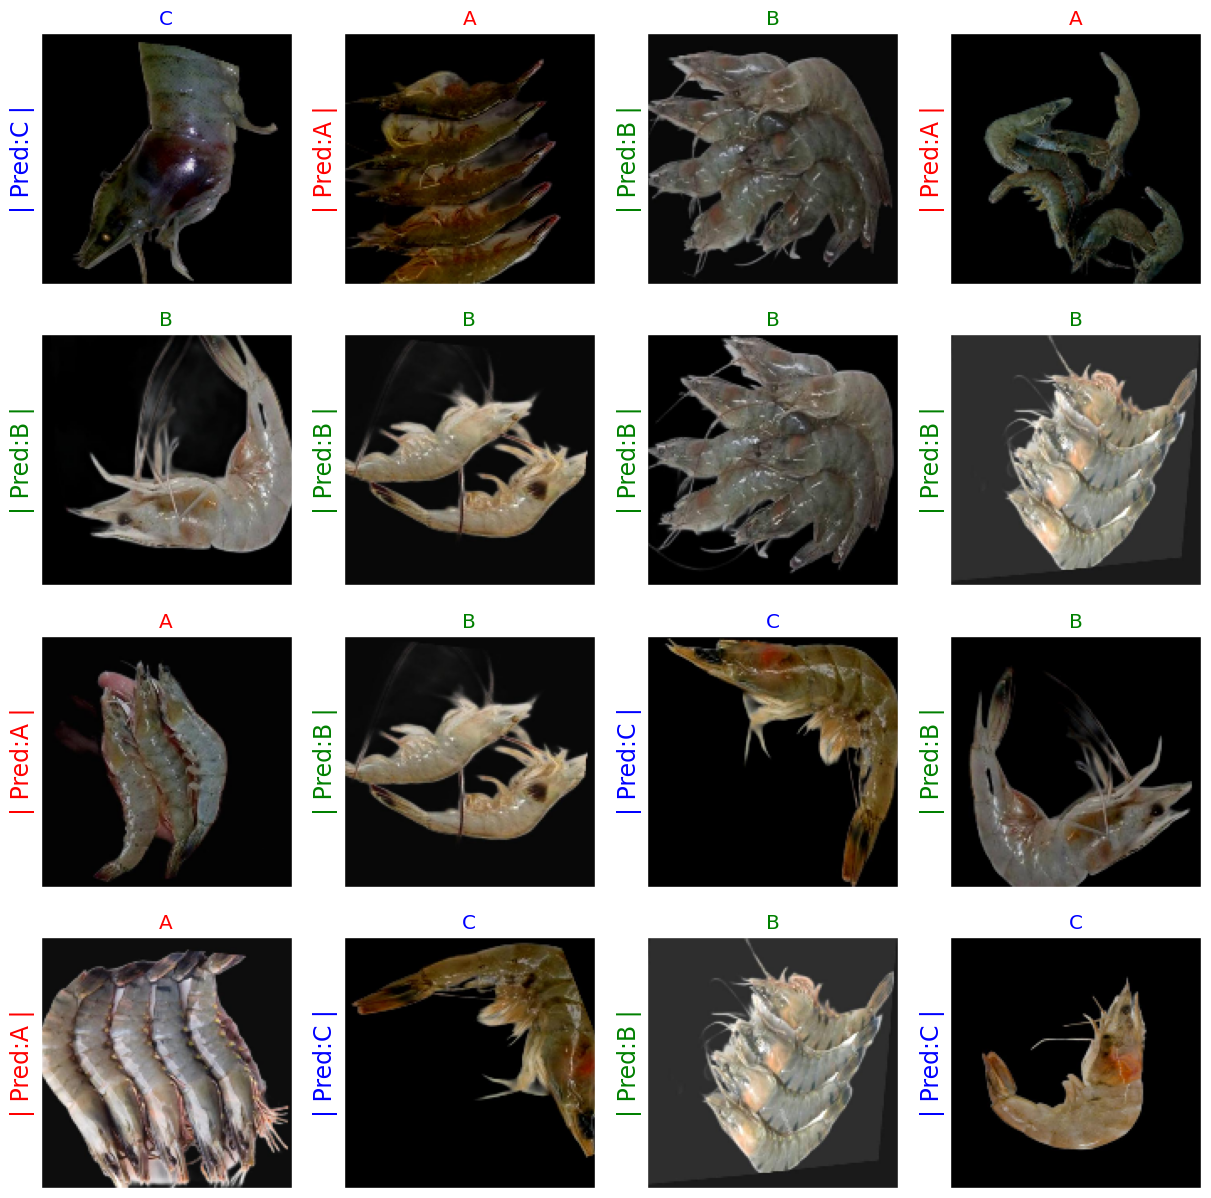

In [255]:
plt.figure(figsize=(15,15))
for i in range(1,17):
    fig = np.random.choice(np.arange(size))
    plt.subplot(4,4,i)
    plt.imshow(image_data[fig])
    if image_target[fig]=='A':
        c='red'
    elif image_target[fig]=='B':
        c='green'
    else:
        c='blue'
    plt.title(image_target[fig], color=c)
    plt.ylabel("| Pred:{} |".format(Prediction(image_data[fig])),fontsize=17, color=c)
    plt.xticks([]), plt.yticks([])
plt.show()

IMG20230517080311_jpg.rf.3451cb7a64a92fbac41b5e84d7e14872.jpg
Prediction range:
Minimum value: 0.00026493936
Maximum value: 0.61800605
Grade: C
Bad
IMG20230517080311_jpg.rf.4581690921b38e87fe05df867066bdaf.jpg
Prediction range:
Minimum value: 0.030139027
Maximum value: 0.77835333
Grade: A
Good
IMG20230517080311_jpg.rf.ac321ed0d06597f17e5b50e9a7c202c4.jpg
Prediction range:
Minimum value: 0.0003824945
Maximum value: 0.66209024
Grade: C
Bad
IMG20230518073006_jpg.rf.282e6290c6e36f85e91ff63973db7bed.jpg
Prediction range:
Minimum value: 0.00073792826
Maximum value: 0.9186719
Grade: A
Good
IMG20230518073006_jpg.rf.369195516dd07c6c088a7f395f54d233.jpg
Prediction range:
Minimum value: 0.0051759277
Maximum value: 0.8344921
Grade: A
Good
IMG20230518073006_jpg.rf.44209138c206e7054bf044759d8dc371.jpg
Prediction range:
Minimum value: 1.4283216e-05
Maximum value: 0.99135816
Grade: A
Good
IMG20230518073009_jpg.rf.27883b0685c40b5d44bd0457650a387f.jpg
Prediction range:
Minimum value: 4.1722687e-06
Maxim

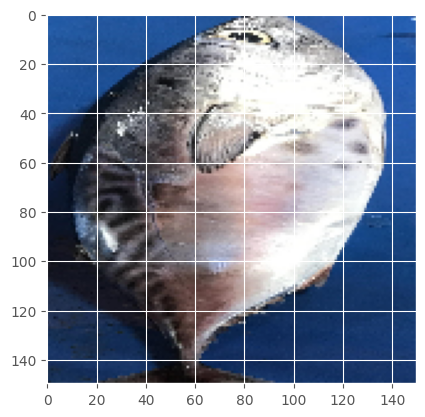

In [256]:


# user_path = r"C:\laragon\www\Project\Bloomy\img\output"
user_path = r"D:\\TITO\\Documents\\BANGKIT\\capstone\\protoype2\\data\\A"

image_files = os.listdir(user_path)
for idx in range(0, 149):
    index = idx
    image_file = os.path.join(user_path, image_files[index])

    print(image_files[index])
    img = image.load_img(image_file, target_size=(150, 150))
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0 

    classes = model.predict(x, batch_size=1)
    nilai_min = np.min(classes)
    nilai_max = np.max(classes)

    print("Prediction range:")
    print("Minimum value:", nilai_min)
    print("Maximum value:", nilai_max)

    class_list = ['A', 'B', 'C'] 

    predicted_class = class_list[np.argmax(classes[0])]
    print('Grade:', predicted_class)

    if predicted_class == 'A':
        print('Good')
    

    elif predicted_class == 'B':
        print('Medium')


    elif predicted_class == 'C':
        print('Bad')

In [257]:
# file_location = 'D:\\Users\\Andra\Documents\\Bloomy\\prototype\\fish_grading.h5'
# file_location = 'C:\laragon\www\Project\Bloomy\model\\fishgrading.h5'
file_location = 'D:\\TITO\\Documents\\BANGKIT\\capstone\\protoype3\\model_mobilenet_1.h5'
model.save(file_location)